In [1]:
# Instructions for submission

# 1. Rename this file to groupXX_PPGHR.ipynb where XX is your group number as visible in the Google spreadsheet
# 2. State the team members (e-mail, legi):
# example@student.ethz.ch, XX-YYY-ZZZ
# JOE MAMA
# FAT ASS
# TO BE FILLED
# 3. Kaggle team name: TO BE FILLED
# 4. Upload this file in a zipped folder together with your final predictions to the provided Polybox link. See the Submission section in the PDF for more details.

In [17]:
# Import necessary libraries
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sktime.regression.deep_learning.resnet import ResNetRegressor
from sktime.regression.deep_learning.cnn import CNNRegressor
from sktime.regression.deep_learning.mcdcnn import MCDCNNRegressor
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import xgboost as xgb


In [2]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def passband_heart(ppg_signal, fs):
    # Bandpass filter to isolate heart rate component
    # : highcut to 160bpm = 2.67Hz
    lowcut = 0.67 / (0.5 * fs)  # 40 bpm
    highcut = 2.67 / (0.5 * fs)  # 240 bpm
    b, a = butter(1, [lowcut, highcut], btype='band')
    filtered_signal = lfilter(b, a, ppg_signal)
    return filtered_signal

def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

In [135]:
def prepare_data(phase,y):
    INTERVAL_LENGTH = 128*30
    X = []
    for i in range(len(y)):
        X.append(phase[i*INTERVAL_LENGTH:(i+1)*INTERVAL_LENGTH])
    return np.array(X)

def prepare_full_data(ppg, accx, accy, accz):
    INTERVAL_LENGTH = 128*30
    # Normalize the PPG signal
    ppg_normalized = normalize_data(ppg)
    accx_normalized = normalize_data(accx)
    accy_normalized = normalize_data(accy)
    accz_normalized = normalize_data(accz)
    ds = []
    for i in range(len(ppg) // INTERVAL_LENGTH):
        ppg_interval = ppg_normalized[i*INTERVAL_LENGTH:(i+1)*INTERVAL_LENGTH]
        accx_interval = accx_normalized[i*INTERVAL_LENGTH:(i+1)*INTERVAL_LENGTH]
        accy_interval = accy_normalized[i*INTERVAL_LENGTH:(i+1)*INTERVAL_LENGTH]
        accz_interval = accz_normalized[i*INTERVAL_LENGTH:(i+1)*INTERVAL_LENGTH]
        ds.append([ppg_interval, accx_interval, accy_interval, accz_interval])
    

    # Combine the normalized signals into a single array
    data = np.array(ds)

    return data

def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

def create_dataloaders_from_arrays(X_train, y_train, X_test, y_test, batch_size=16):
    # Convert arrays to PyTorch tensors
    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)
    X_test = np.array(X_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)
    X_train_torch = torch.tensor(X_train)
    y_train_torch = torch.tensor(y_train)
    X_test_torch = torch.tensor(X_test)
    y_test_torch = torch.tensor(y_test)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_torch, y_train_torch)
    test_dataset = TensorDataset(X_test_torch, y_test_torch)

    # Create DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_model(model, train_loader, num_epochs=10):
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using device {device}')
    model = model.to(device)

    # Define the loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

    return model

    
def predict(model, data):
    # Convert the data to a PyTorch tensor and add an extra dimension
    data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_tensor = data_tensor.to(device)
    model = model.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make the prediction
    with torch.no_grad():
        output = model(data_tensor)

    # Convert the output tensor to a numpy array and return it
    return output.cpu().numpy()

def prepare_full_data_xgb(ppg,accx,accy,accz):
    INTERVAL_LENGTH = 128*30
    # Normalize the PPG signal
    ppg_normalized = normalize_data(ppg)
    accx_normalized = normalize_data(accx)
    accy_normalized = normalize_data(accy)
    accz_normalized = normalize_data(accz)
    ds = []
    for i in range(len(ppg) // INTERVAL_LENGTH):
        ppg_interval = ppg_normalized[i*INTERVAL_LENGTH:(i+1)*INTERVAL_LENGTH]
        accx_interval = accx_normalized[i*INTERVAL_LENGTH:(i+1)*INTERVAL_LENGTH]
        accy_interval = accy_normalized[i*INTERVAL_LENGTH:(i+1)*INTERVAL_LENGTH]
        accz_interval = accz_normalized[i*INTERVAL_LENGTH:(i+1)*INTERVAL_LENGTH]
        ds.append(np.concatenate((ppg_interval, accx_interval, accy_interval, accz_interval)))
    

    # Combine the normalized signals into a single array
    data = np.array(ds)
    print('data shape:', data.shape)

    return data


In [136]:
sampling_rate = 128  # Hz

# Load data item containing the PPG, HR, and IMU signals from all phases
data = np.load('mhealth24_data_public.npy', allow_pickle=True).item() # now it is a dict

print('Keys for data:', data.keys())

# Example to extract the data from phase 0
# phase 0,3: wrist
# testing: phases 1,3,5
phase0_data = data['phase 0']
phase1_data = data['phase 1']
phase2_data = data['phase 2']
phase3_data = data['phase 3']
phase4_data = data['phase 4']
phase5_data = data['phase 5']
print('Keys for phase 0:', phase0_data.keys())

# Get the individual signals from phase 0
ppg_phase0 = phase0_data['PPG wrist']
ref_hr_phase0 = phase0_data['ground truth HR']  # only available for phase 0, 2, and 4 (training data)
IMU_X_phase0 = phase0_data['IMU X wrist']
IMU_Y_phase0 = phase0_data['IMU Y wrist']
IMU_Z_phase0 = phase0_data['IMU Z wrist']
ppg_phase1 = phase1_data['PPG head']
IMU_X_phase1 = phase1_data['IMU X head']
IMU_Y_phase1 = phase1_data['IMU Y head']
IMU_Z_phase1 = phase1_data['IMU Z head']
ppg_phase2 = phase2_data['PPG head']
ref_hr_phase2 = phase2_data['ground truth HR']
IMU_X_phase2 = phase2_data['IMU X head']
IMU_Y_phase2 = phase2_data['IMU Y head']
IMU_Z_phase2 = phase2_data['IMU Z head']
ppg_phase3 = phase3_data['PPG wrist']
IMU_X_phase3 = phase3_data['IMU X wrist']
IMU_Y_phase3 = phase3_data['IMU Y wrist']
IMU_Z_phase3 = phase3_data['IMU Z wrist']
ppg_phase4 = phase4_data['PPG head']
ref_hr_phase4 = phase4_data['ground truth HR']
IMU_X_phase4 = phase4_data['IMU X head']
IMU_Y_phase4 = phase4_data['IMU Y head']
IMU_Z_phase4 = phase4_data['IMU Z head']
ppg_phase5 = phase5_data['PPG head']
IMU_X_phase5 = phase5_data['IMU X head']
IMU_Y_phase5 = phase5_data['IMU Y head']
IMU_Z_phase5 = phase5_data['IMU Z head']



Keys for data: dict_keys(['phase 0', 'phase 1', 'phase 2', 'phase 3', 'phase 4', 'phase 5'])
Keys for phase 0: dict_keys(['ground truth HR', 'PPG wrist', 'IMU X wrist', 'IMU Y wrist', 'IMU Z wrist'])


In [137]:
data_x = np.concatenate((ppg_phase2, ppg_phase4), axis=0)
y = np.concatenate((ref_hr_phase2, ref_hr_phase4), axis=0)
data_x.shape, y.shape

((1739520,), (453,))

In [138]:
y = ref_hr_phase0

sig_flt = passband_heart(ppg_phase0, sampling_rate)
X = prepare_data(sig_flt,y)
X = normalize_data(X)
X_train, X_test, y_train, y_test = split_data(X, y)

In [214]:
D = prepare_full_data(ppg_phase4, IMU_X_phase4, IMU_Y_phase4, IMU_Z_phase4)
print(D.shape)
D_train, D_test, yD_train, yD_test = split_data(D, ref_hr_phase4)

(57, 4, 3840)


In [208]:
XGB_D_0 = prepare_full_data_xgb(passband_heart(ppg_phase0, sampling_rate), IMU_X_phase0, IMU_Y_phase0, IMU_Z_phase0)
XGB_D_1 = prepare_full_data_xgb(passband_heart(ppg_phase1, sampling_rate), IMU_X_phase1, IMU_Y_phase1, IMU_Z_phase1)
XGB_D_2 = prepare_full_data_xgb(passband_heart(ppg_phase2, sampling_rate), IMU_X_phase2, IMU_Y_phase2, IMU_Z_phase2)
XGB_D_3 = prepare_full_data_xgb(passband_heart(ppg_phase3, sampling_rate), IMU_X_phase3, IMU_Y_phase3, IMU_Z_phase3)
XGB_D_4 = prepare_full_data_xgb(passband_heart(ppg_phase4, sampling_rate), IMU_X_phase4, IMU_Y_phase4, IMU_Z_phase4)
XGB_D_5 = prepare_full_data_xgb(passband_heart(ppg_phase5, sampling_rate), IMU_X_phase5, IMU_Y_phase5, IMU_Z_phase5)
XGB_D_train, XGB_D_test, yXGB_D_train, yXGB_D_test = split_data(XGB_D_4, ref_hr_phase4)

data shape: (396, 15360)
data shape: (396, 15360)
data shape: (396, 15360)
data shape: (396, 15360)
data shape: (57, 15360)
data shape: (57, 15360)


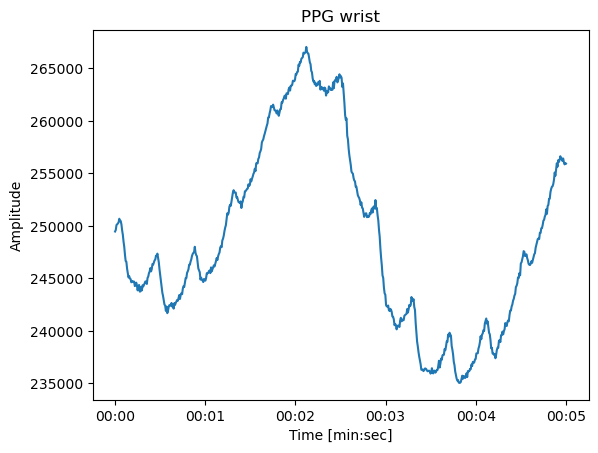

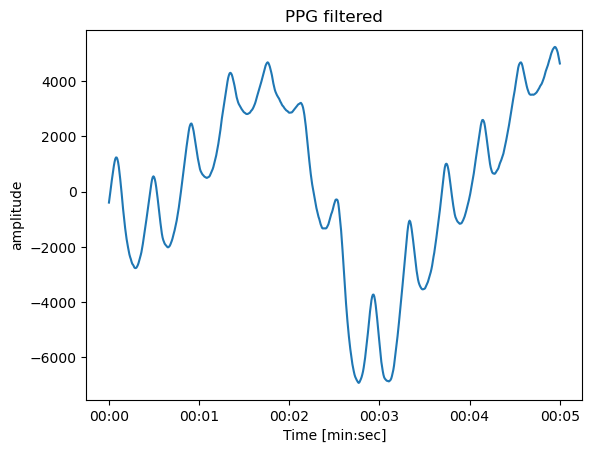

In [260]:
# Function to plot any signal with time on the x-axis
def plot_signal(signal, title, ylabel, sampling_rate=128):
    x = np.linspace(0, len(signal) / sampling_rate, len(signal))
    t = pd.to_datetime(x, unit='s')

    fig, ax = plt.subplots()
    ax.plot(t, signal)
    ax.set_title(title)
    ax.set_xlabel('Time [min:sec]')
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
    plt.show()

# If you want to be able to interactively look at your plotted data (e.g., zooming in or out),
# uncomment the line with "%matplotlib widget" below
# Careful: This does not work on Kaggle, but requires that you run the Jupyter Notebook locally on your computer
# If you have an interactive plot and you want to go back to the non-interactive plot, comment the line with 
# "%matplotlib widget" out and restart your kernel
# If you accidently run this script on Kaggle when "%matplotlib widget" is not commented out and you receive an error afterwards that your plot cannot be plotted, comment "%matplotlib widget" out and restart the kernel via "Run << Factory reset"

# %matplotlib widget

# Example plot of a 10-second window of the PPG signal
plot_window_start = 320  # in seconds
plot_window_end = 325  # in seconds
plot_signal(ppg_phase4[plot_window_start*sampling_rate:plot_window_end*sampling_rate], 'PPG wrist', 'Amplitude')
plot_signal(passband_heart(ppg_phase4, sampling_rate)[plot_window_start*sampling_rate:plot_window_end*sampling_rate], 'PPG filtered', 'amplitude')


In [10]:
# Function to print the mean and median absolute error between your predicted HR and the reference HR
# With this function, you can evaluate the resulting score that you would obtain on the public dataset
# with your predicted HR values on Kaggle
def print_score(pred_hr, ref_hr):
    err = np.abs(np.asarray(pred_hr) - np.asarray(ref_hr))
    print("Mean error: {:4.3f}, Median error {:4.3f}".format(np.mean(err), np.median(err)))
    s = 0.5 * np.mean(err) + 0.5 * np.median(err)
    print("Resulting score {:4.3f}".format(s))
    return s

# Example on how to use the print_score function with randomly generated HR values as the predictions
pred_hr_phase0 = list(np.random.randint(40, 180, len(ref_hr_phase0)))
_ = print_score(pred_hr_phase0, ref_hr_phase0)

Mean error: 45.880, Median error 40.329
Resulting score 43.105


In [11]:
# For each phase, you should now have obtained a list of predicted HR values
# Below, we give an example of how you can produce the submission.csv file from your predicted HR values
# To demonstrate the format of the submission.csv file, we provide an example with randomly generated HR values
# For phase 0, 1, 2, and 3 you should each obtain 396 HR values
# For phase 4 and 5 you should each obtain 57 HR values
# IMPORTANT: You have to replace the following predicted HR values with your predicted HR values!
pred_hr_phase0 = list(np.random.randint(40, 180, 396))
pred_hr_phase1 = list(np.random.randint(40, 180, 396))
pred_hr_phase2 = list(np.random.randint(40, 180, 396))
pred_hr_phase3 = list(np.random.randint(40, 180, 396))
pred_hr_phase4 = list(np.random.randint(40, 180, 57))
pred_hr_phase5 = list(np.random.randint(40, 180, 57))

# You can keep the below code unchanged to produce the submission.csv file
pred_hr_phases = [pred_hr_phase0, pred_hr_phase1, pred_hr_phase2,
                  pred_hr_phase3, pred_hr_phase4, pred_hr_phase5]
ids = []
pred_hr_flattened = []

for phase_counter in range(len(pred_hr_phases)):
    for hr_counter in range(len(pred_hr_phases[phase_counter])):
        pred_hr_flattened.append(pred_hr_phases[phase_counter][hr_counter])
        ids.append(f'phase{phase_counter}_{hr_counter}')

# If you use Kaggle, on the right side in tab "Output", you should now see a file called "submission.csv" after pressing "refresh"
# Download the file and submit it to the competition on Kaggle to obtain a score on the leaderboard for your team
df = pd.DataFrame({'Id': ids, 'Predicted': pred_hr_flattened})
df.to_csv('submission.csv', index=False)

In [12]:
def better_score(pred, ref, desc):
    # Calculate the score
    score = print_score(pred, ref)
    with open('losses.txt', 'a') as f:
        f.write("Score for " + desc + ": " + str(score) + "\n")
    return score

In [107]:
clf = ResNetRegressor(n_epochs=10, batch_size=4) 
clf.fit(D_train, yD_train) 

#transferlearning XGBoost

ResNetRegressor(batch_size=4, n_epochs=10)

In [258]:
clf_cnn = CNNRegressor(n_epochs=500, batch_size=16, kernel_size=49, avg_pool_size=21)
clf_cnn.fit(D_train, yD_train)

CNNRegressor(avg_pool_size=21, kernel_size=49, n_epochs=500)

In [259]:
pred = clf_cnn.predict(D_test)
print_score(pred, yD_test)

1/1 [==============================] - 0s 98ms/step
Mean error: 18.963, Median error 14.225
Resulting score 16.594


16.594121276804678

In [244]:
class MyModel(nn.Module):
    #TODO: deeper mode, conv layers, dropout
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc0 = nn.Linear(128*30, 1024)
        self.fc00 = nn.Linear(1024, 1024)
        self.fc1 = nn.Linear(1024, 512)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.25)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 1)
    
    def forward(self, x):
        #x = x.view(x.size(0), -1)
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc00(x))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        self.dropout2(x)
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [246]:
class MyModel2(nn.Module):
    def __init__(self):
        super(MyModel2, self).__init__()
        self.fc0 = nn.Linear(128*30, 1024)
        self.dropout0 = nn.Dropout(p=0.5)
        self.fc00 = nn.Linear(1024, 1024)
        self.dropout00 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(1024, 512)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(128, 32)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc0(x))
        x = self.dropout0(x)
        x = torch.relu(self.fc00(x))
        x = self.dropout00(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

In [247]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(4, 8, kernel_size=63, padding=1) #3840 -> 3588
        self.maxpool1 = nn.MaxPool1d(3) #3588 -> 1196
        self.conv2 = nn.Conv1d(8, 16, kernel_size=31, padding=1) #1196 -> 1132
        self.maxpool2 = nn.MaxPool1d(2) #1132 -> 566
        self.conv3 = nn.Conv1d(16, 32, kernel_size=15, padding=1) #566 -> 552
        self.avgpool1 = nn.AvgPool1d(3) #552 -> 185
        self.fc1 = nn.Linear(201*32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.do = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
    
    def forward(self, x):
        #x = x.unsqueeze(1)
        x = self.maxpool1(torch.relu(self.conv1(x)))
        x = self.maxpool2(torch.relu(self.conv2(x)))
        x = self.avgpool1(torch.relu(self.conv3(x)))
        x = x.view(-1, 201*32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.do(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [243]:
train_loader, test_loader = create_dataloaders_from_arrays(D_train, yD_train, D_test, yD_test)
train_loader.dataset[0][0].shape

torch.Size([4, 3840])

In [248]:
model = MyModel()
model2 = MyModel2()
conv_net = ConvNet()
#TODO: increase num_epochs
train_model(model, train_loader, num_epochs=1000)

Using device cpu


c:\Users\lucas\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\lucas\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/1000], Loss: 21770.693359375
Epoch [2/1000], Loss: 15878.1689453125
Epoch [3/1000], Loss: 11592.7177734375
Epoch [4/1000], Loss: 2872.862548828125
Epoch [5/1000], Loss: 5913.43505859375
Epoch [6/1000], Loss: 2490.01416015625


KeyboardInterrupt: 

In [50]:
pred = predict(conv_net, D_test.astype(np.float32)[0])

In [51]:
better_score(pred, yD_test, 'ConvNet 1/2 s kernels')

Mean error: 17.742, Median error 15.453
Resulting score 16.597


16.597091507823286

In [18]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
       
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 2070


In [105]:
clf_cnn.model_.get_config()

{'name': 'model_4',
 'trainable': True,
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 3840, 4),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_5'},
   'name': 'input_5',
   'inbound_nodes': []},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d_26',
    'trainable': True,
    'dtype': 'float32',
    'filters': 6,
    'kernel_size': (7,),
    'strides': (1,),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1,),
    'groups': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv1d_26',
   'inbound_nodes': [[['input_5', 0, 0, {}]]]},
  {'class_name': 'Ave

In [199]:
xgb_reg_model_wrist = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 20, alpha = 15, n_estimators = 1000, subsample = 0.8)
# phase0, all data, objective ='reg:squarederror', learning_rate = 0.1, max_depth = 20, alpha = 15, n_estimators = 1000, subsample = 0.8, 4.352
xgb_reg_model_head = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 25, alpha = 10, n_estimators = 500, subsample = 0.8)
# phase2, all data, objective ='reg:squarederror', learning_rate = 0.1, max_depth = 25, alpha = 10, n_estimators = 500, subsample = 0.8, 5.55

In [210]:
xgb_reg_model_head2 = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 25, alpha = 10, n_estimators = 500, subsample = 0.8)

In [204]:
xgb_reg_model_wrist.fit(XGB_D_train, yXGB_D_train)

XGBRegressor(alpha=15, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [200]:
xgb_reg_model_head.fit(XGB_D_train, yXGB_D_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=25, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [211]:
xgb_reg_model_head2.fit(XGB_D_train, yXGB_D_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=25, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [207]:
predsxgb_0 = xgb_reg_model_wrist.predict(XGB_D_0)
predsxgb_1 = xgb_reg_model_head.predict(XGB_D_1)
predsxgb_2 = xgb_reg_model_head.predict(XGB_D_2)
predsxgb_3 = xgb_reg_model_wrist.predict(XGB_D_3)

In [212]:
predsxgb = xgb_reg_model_wrist.predict(XGB_D_test)
print_score(predsxgb, yXGB_D_test)

Mean error: 96.082, Median error 98.457
Resulting score 97.269


97.26942773049036

In [229]:
np.max(ref_hr_phase4)

174.26820966643976